# Exploratory Analysis

This notebook follows on from `00_download_data` notebook which shows how the data was downloaded from a freely available API. This notebooks focuses on the exploring data particularly in two areas:
1. The Frequency of Tags
2. The number of votes each tag has for game

These two area are explored such that tags which occur infrequently are removed from the data set as they will introduce noise. Secondly, tags which have a low frequency of votes should also potentially be removed as these tags may not best represent the game and the model may overfit as a result of these tags.

Let's start by importing the modules we need. The plotting will be done with seaborn.

In [1]:
from collections import Counter
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

In [2]:
sns.set(rc={'figure.figsize':(15,8)})

In [3]:
os.chdir('..')

Get a list of game files we have

In [5]:
game_files = os.listdir('./data/games')

In [6]:
len(game_files)

33252

we have data for over 30,000 steam games.

## Tag Votes

This section will look at the distribution of the votes for each tag for every game in the dat set. Let's first extract the number of frequency of votes a tag has for each game

In [7]:
tag_freqs = []
for game in game_files:
    with open(f'./data/games/{game}', 'r') as in_json:
        game_data = json.load(in_json)
        game_tags = game_data['tags']
        if game_tags:
            for k, v in game_tags.items():
                tag_freqs.append(v)

In [12]:
tag_freqs = np.array(tag_freqs)

Plot the distribution:

Text(0.5, 0, 'Vote for a Tag (per game)')

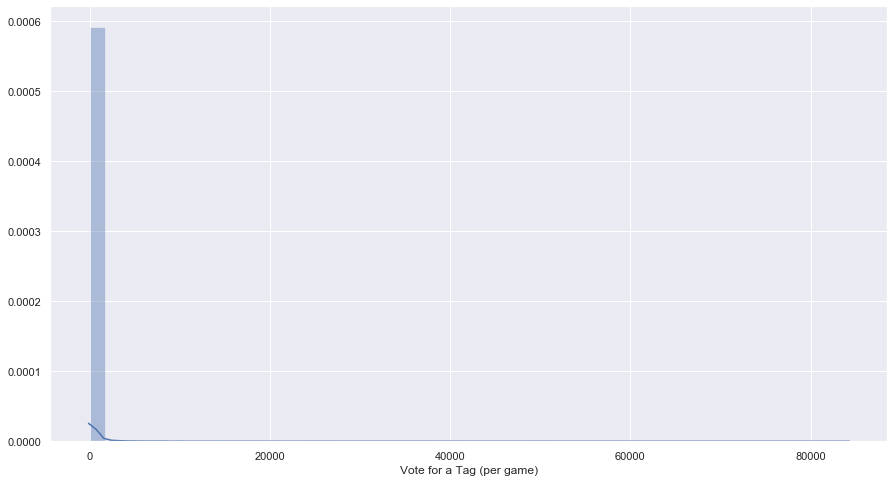

In [9]:
sns.distplot(tag_freqs)
plt.xlabel('Vote for a Tag (per game)')

Unsurprsingly we have a heavily skewed distribution. Looks like most games have very little votes for a tag.

Some summary stats:

In [10]:
print(f'Mean of Tag Votes: {np.mean(tag_freqs)}')
print(f'Median of Tag Votes: {np.median(tag_freqs)}')

Mean of Tag Votes: 66.53283525749076
Median of Tag Votes: 22.0


In [13]:
pd.Series(tag_freqs).describe()

count    267563.000000
mean         66.532835
std         549.068984
min           1.000000
25%          12.000000
50%          22.000000
75%          35.000000
max       84173.000000
dtype: float64

A lot of games have tags will very few votes, we should remove these. How do the numbers look when we look at quantiles:

In [28]:
for i in np.linspace(0.05, 1, num=20):
    quantile = np.quantile(tag_freqs, i)
    n_tags = tag_freqs[tag_freqs <= quantile].shape[0]
    percent = f'{n_tags / tag_freqs.shape[0] * 100:.2f}'
    print(f'Qauntile: {i:.2f}   Frequency: {quantile}    N Tags: {n_tags}    Percentage: {percent}')

Qauntile: 0.05   Frequency: 7.0    N Tags: 13558    Percentage: 5.07
Qauntile: 0.10   Frequency: 10.0    N Tags: 36276    Percentage: 13.56
Qauntile: 0.15   Frequency: 11.0    N Tags: 54954    Percentage: 20.54
Qauntile: 0.20   Frequency: 11.0    N Tags: 54954    Percentage: 20.54
Qauntile: 0.25   Frequency: 12.0    N Tags: 68371    Percentage: 25.55
Qauntile: 0.30   Frequency: 14.0    N Tags: 83687    Percentage: 31.28
Qauntile: 0.35   Frequency: 17.0    N Tags: 96101    Percentage: 35.92
Qauntile: 0.40   Frequency: 20.0    N Tags: 109854    Percentage: 41.06
Qauntile: 0.45   Frequency: 21.0    N Tags: 131451    Percentage: 49.13
Qauntile: 0.50   Frequency: 22.0    N Tags: 143521    Percentage: 53.64
Qauntile: 0.55   Frequency: 23.0    N Tags: 150752    Percentage: 56.34
Qauntile: 0.60   Frequency: 26.0    N Tags: 163553    Percentage: 61.13
Qauntile: 0.65   Frequency: 30.0    N Tags: 175694    Percentage: 65.66
Qauntile: 0.70   Frequency: 32.0    N Tags: 191033    Percentage: 71.40
Q

Wow, 90% of tags present for games have less than or equal to 80 votes, which isn't a lot. Given that we will lose potentially a lot of tags if we set a threshold for the vote count to be higher it should result in a model that derives meaningful relationships between tags. It's a dark art to determine the threshold bit I feel going for tags with a least 100 votes should help remove a lot of the noise.

How many tags do we retain if we set the threshold to 100:

In [31]:
tag_freqs[np.array(tag_freqs) >= 100].shape

(21613,)

Only 21,613 from 267,563! We now have less tags than there are games! This would suggest to me that we have a lot of games with low tag frequencies, probably from indie developers with small player counts.

Let's set the minimum number of votes for a tag on a game to be 100

In [32]:
TAG_VOTES_MIN = 100

## Tag Frequencies Per Game

Now lets look at how tags occur across all games and also removing tags that have less than 100 votes

In [34]:
tag_occurrence = {}
for game in game_files:
    with open(f'./data/games/{game}', 'r') as in_json:
        game_data = json.load(in_json)
        game_tags = game_data['tags']
        if game_tags:
            for k, v in game_tags.items():
                if v >= TAG_VOTES_MIN:
                    tag_occurrence[k] = tag_occurrence.get(k, 0) + 1

In [35]:
tag_occurrence['Action']

1166

Some summary stats:

In [36]:
pd.Series(list(tag_occurrence.values())).describe()

count     370.000000
mean       58.413514
std       131.034902
min         1.000000
25%         6.000000
50%        15.000000
75%        47.750000
max      1166.000000
dtype: float64

We have a tag(s) that only appears once which won't help the model build any meaningful relationships between the tags. These tags and low frequency tags should be removed.

Looking at the quantiles:

In [37]:
for i in np.linspace(0.05, 1, num=20):
    print(f'Qauntile: {i:.2f}   Frequency: {np.quantile(list(tag_occurrence.values()), i)}')

Qauntile: 0.05   Frequency: 1.0
Qauntile: 0.10   Frequency: 2.0
Qauntile: 0.15   Frequency: 4.0
Qauntile: 0.20   Frequency: 5.0
Qauntile: 0.25   Frequency: 6.0
Qauntile: 0.30   Frequency: 7.0
Qauntile: 0.35   Frequency: 9.0
Qauntile: 0.40   Frequency: 10.0
Qauntile: 0.45   Frequency: 12.0
Qauntile: 0.50   Frequency: 15.0
Qauntile: 0.55   Frequency: 17.0
Qauntile: 0.60   Frequency: 20.0
Qauntile: 0.65   Frequency: 27.0
Qauntile: 0.70   Frequency: 35.30000000000001
Qauntile: 0.75   Frequency: 47.75
Qauntile: 0.80   Frequency: 68.39999999999998
Qauntile: 0.85   Frequency: 88.0
Qauntile: 0.90   Frequency: 143.10000000000002
Qauntile: 0.95   Frequency: 266.70000000000016
Qauntile: 1.00   Frequency: 1166.0


The lower quantiles are dominated by tags the occure infrequently.

Let's plot the frequency of tag frequencies:

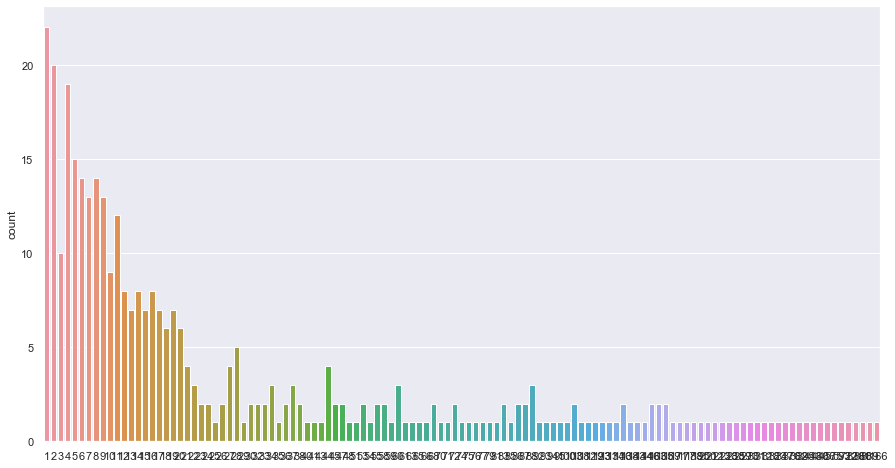

In [38]:
sns.countplot(list(tag_occurrence.values()))

Yup, lot's of tags with low frequencies. We have over 20 tags that only appear once in the data set.

In [41]:
tag_occurrence_vals = np.array(list(tag_occurrence.values()))
tag_occurrence_vals.shape

(370,)

We need to set a threshold for the minimum number of times a tag must appear to be retained. How does the threshold influence the number of tags retained:

Text(0.5, 1.0, 'Tag Frequency Threshold vs. Number of Tags Retained')

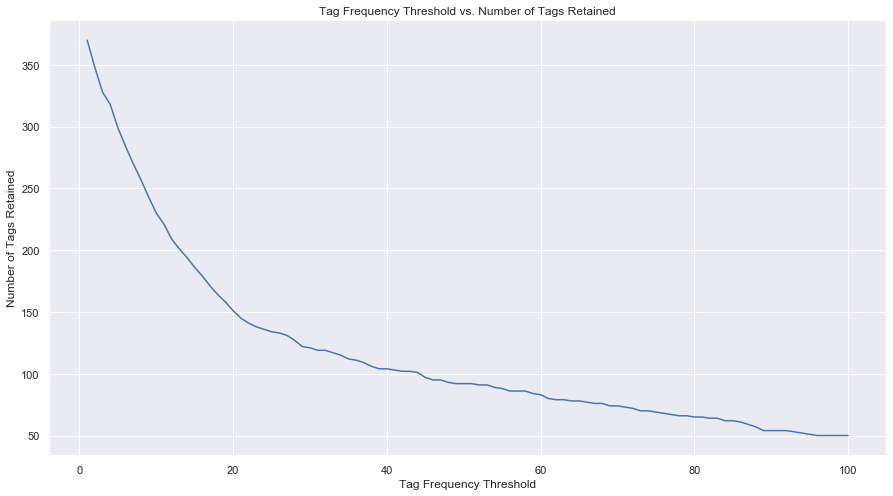

In [54]:
sns.lineplot(
    [i for i in range(1, 101, 1)],
    [tag_occurrence_vals[tag_occurrence_vals >= i].shape[0] for i in range(1, 101, 1)]
)
plt.xlabel('Tag Frequency Threshold')
plt.ylabel('Number of Tags Retained')
plt.title('Tag Frequency Threshold vs. Number of Tags Retained')

The graph clearly shows as the tag threshold increases the number of tags retained drops (duh!), but a takeaway from this plot is the number of tags retained begins to plateau meaning as tag frequency increases the number of tags that are dropped decreases. From the graph I think a threshold of around 20 would be decent. This means that a tag must appear in at least 20 games to be retained.

In [75]:
MIN_TAG_FREQ_GAME = 20

Make a `dict` of all the tags to keep bases on the minimum number of games they must appear in. 

In [76]:
game_tags_keep = {game : tag_occurrence[game] for game in tag_occurrence if tag_occurrence[game] >= MIN_TAG_FREQ_GAME}

Now, create a final data set where both the filters are applied:
- A tag must have at least 100 votes for a particular game
- A tag must appear in at least 20 games

In [77]:
final_data = {}
for game in game_files:
    with open(f'./data/games/{game}', 'r') as in_json:
        game_data = json.load(in_json)
        final_data[game_data['name']] = []
        game_tags = game_data['tags']
        if game_tags:
            for k, v in game_tags.items():
                if (k in game_tags_keep) and (v >= TAG_VOTES_MIN):
                    final_data[game_data['name']].append(k)

In [78]:
len(final_data)

33155

Some of the games won't have any tag data due the filters removing all of their tags. Let's removed those games with no tags.

In [79]:
keys_to_remove = [k for k, v in final_data.items() if not v]
for key in keys_to_remove:
    final_data.pop(key, None)

In [80]:
len(final_data)

3027

Over 3000 games in the final data set

In [66]:
with open('./games_with_tags_double_filter.json', 'w') as out:
    json.dump(final_data, out)

In [82]:
list(game_tags_keep.keys())

['Action',
 'FPS',
 'Multiplayer',
 'Shooter',
 'Classic',
 'Team-Based',
 'First-Person',
 'Competitive',
 'Tactical',
 'PvP',
 'Military',
 'Strategy',
 'Masterpiece',
 'Survival',
 'Assassin',
 'Sexual Content',
 'Nudity',
 'Mature',
 'Anime',
 'Casual',
 'Indie',
 'Simulation',
 'Adventure',
 'Zombies',
 'World War II',
 'Co-op',
 'Moddable',
 'Singleplayer',
 'War',
 'Online Co-Op',
 'Gore',
 'Historical',
 'Great Soundtrack',
 'Horror',
 'Open World',
 'Third Person',
 'Parkour',
 'Violent',
 'Hack and Slash',
 'Action-Adventure',
 'Sci-fi',
 'RPG',
 'Story Rich',
 'Atmospheric',
 'Psychological Horror',
 'Fantasy',
 'Action RPG',
 'Magic',
 'Character Customization',
 'Exploration',
 'Free to Play',
 'Tower Defense',
 'Comedy',
 'Relaxing',
 'Pixel Graphics',
 'Turn-Based Strategy',
 "Beat 'em up",
 'Dating Sim',
 'Early Access',
 'City Builder',
 'Puzzle',
 'Building',
 'Colony Sim',
 'Turn-Based Tactics',
 'Turn-Based',
 'Third-Person Shooter',
 'Grand Strategy',
 'RTS',
 'Bas